In [20]:
import boto3
import json
import datetime
import pandas as pd
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

CANSERVER_PARSED_BUCKET = 'matt3r-canserver-us-west-2'
CANSERVER_EVENT_BUCKET = 'matt3r-canserver-event-us-west-2'
IMU_BUCKET = 'matt3r-imu-us-west-2'
s3_client = boto3.client('s3')

In [3]:
start_date_str = '2023-05-25'
end_date_str = '2023-05-25'
start_date = datetime.datetime.strptime(start_date_str, '%Y-%m-%d')
end_date = datetime.datetime.strptime(end_date_str, '%Y-%m-%d')

11199.977278470993
49.96788167953491
-0.0028310214898144828
0.03800405948035769
0.01634285792144599


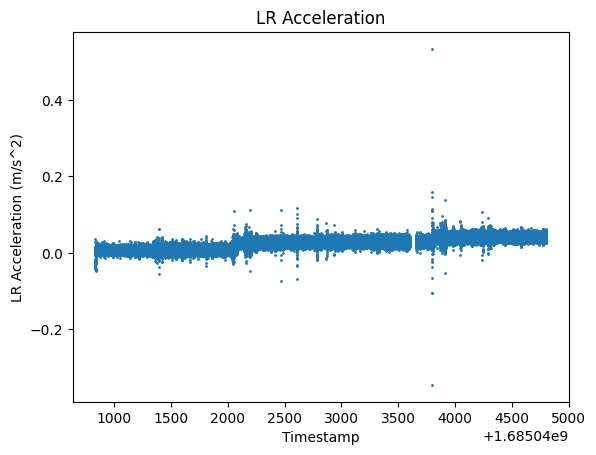

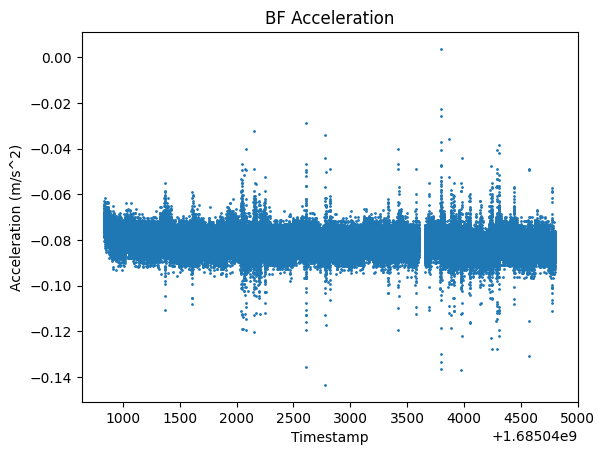

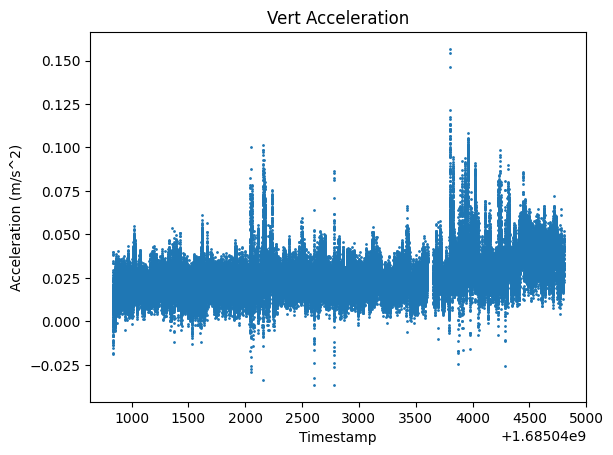

In [26]:
# getting the parquet files from the IMU bucket

# get a list of all parquet files in the prefix and filter them to within the date range
response = s3_client.list_objects(Bucket=IMU_BUCKET, Prefix="hamid/k3y-78f8031e/accel/")
all_keys = [item['Key'] for item in response['Contents']]
keys = [file for file in all_keys if file.split('.')[-1] == 'parquet'
        and file.split('/')[-1].split('_')[0] != 'raw'
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') >= start_date
        and datetime.datetime.strptime(file.split('/')[-1].split('_')[0], '%Y-%m-%d') <= end_date]
keys = sorted(keys, key=lambda x: x.split('/')[-1].split('.')[0])

# retrieve and combine filtered perquet files
df_list = []
for key in keys:
    response = s3_client.get_object(Bucket=IMU_BUCKET, Key=key)
    buffer = BytesIO(response['Body'].read())
    df = pd.read_parquet(buffer, engine='pyarrow')
    df_list.append(df)
df = pd.concat(df_list, axis=0, ignore_index=True)

# drop any nan values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# process any gaps in the data so it has the correct start time
stale_time = 60
max_jump = df['timestamp(epoch in sec)'].diff().max()
print(max_jump)
while(max_jump > stale_time):
    time_jump_index = df['timestamp(epoch in sec)'].diff().argmax()
    df = df.iloc[time_jump_index :].reset_index(drop=True)
    max_jump = df['timestamp(epoch in sec)'].diff().max()
print(max_jump)

mbf, b = np.polyfit(df['timestamp(epoch in sec)'], df['bf_acc(m/s^2)'], 1)
mlr, b = np.polyfit(df['timestamp(epoch in sec)'], df['lr_acc(m/s^2)'], 1)
mvert, b = np.polyfit(df['timestamp(epoch in sec)'], df['vert_acc(m/s^2)'], 1)
print(mbf*3600)
print(mlr*3600)
print(mvert*3600)

fig, ax = plt.subplots()
ax.scatter(x=df['timestamp(epoch in sec)'], y=df['lr_acc(m/s^2)'], s=1)
plt.title(f'LR Acceleration', wrap = True)
plt.xlabel('Timestamp')
plt.ylabel('LR Acceleration (m/s^2)')

plt.show()

fig, ax = plt.subplots()
ax.scatter(x=df['timestamp(epoch in sec)'], y=df['bf_acc(m/s^2)'], s=1)
plt.title(f'BF Acceleration', wrap = True)
plt.xlabel('Timestamp')
plt.ylabel('Acceleration (m/s^2)')

plt.show()

fig, ax = plt.subplots()
ax.scatter(x=df['timestamp(epoch in sec)'], y=df['vert_acc(m/s^2)'], s=1)
plt.title(f'Vert Acceleration', wrap = True)
plt.xlabel('Timestamp')
plt.ylabel('Acceleration (m/s^2)')

# plt.text(0.02, 0.95, f'Slope: {m:.3f} s/h', transform=plt.gca().transAxes)

plt.show()

In [22]:
# testing to see what gets written to infer
df_infer = pd.read_parquet('/home/tyler/Documents/Matt3r/IMU_validation/2023-05-19.parquet')
print(df_infer[:3])

Empty DataFrame
Columns: [timestamp(epoch in sec), harsh_break(value), harsh_forward_acc(value)]
Index: []
